In [1]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import rankdata, genpareto
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns

In [2]:
df_cleaned = pd.read_excel("Saudi_Brent.xlsx")

In [3]:
df_cleaned

,Date,Close_nifty,Brent_INR
0,2015-01-20,8483.620117,174.385664
1,2015-01-21,8393.809570,174.423174
2,2015-01-22,8421.719727,172.885249
3,2015-01-23,NaN,175.135871
4,2015-01-26,8480.099609,172.810229
...,...,...,...
2648,2024-03-25,12656.940430,323.225674
2649,2024-03-26,12585.540039,322.213015
2650,2024-03-27,12607.980469,318.574945
2651,2024-03-28,12565.889648,323.188168


In [4]:
missing_values = df_cleaned.isnull().sum()
print(missing_values)

Date             0
Close_nifty    551
Brent_INR      315
dtype: int64


In [5]:
# Drop rows where both 'Close_cac' and 'Brent_Euro' are NaN
df = df_cleaned.dropna(how='all', subset=['Close_nifty', 'Brent_INR'])

In [6]:
missing_values = df.isnull().sum()
print(missing_values)

Date             0
Close_nifty    545
Brent_INR      309
dtype: int64


In [7]:
# # Filter the data
# pre_covid_data = df[(df['Date'] >= pre_covid_start) & (df['Date'] <= pre_covid_end)]
# covid_data = df[(df['Date'] >= covid_start) & (df['Date'] <= covid_end)]
# post_covid_data = df[(df['Date'] >= post_covid_start) & (df['Date'] <= post_covid_end)]

# # Optional: Print the shapes of the segmented DataFrames to confirm the division
# print("Pre-Covid Data Shape:", pre_covid_data.shape)
# print("Covid Data Shape:", covid_data.shape)
# print("Post-Covid Data Shape:", post_covid_data.shape)

# # Optional: Save the segmented data to CSV files if needed
# pre_covid_data.to_csv('pre_covid_data.csv', index=False)
# covid_data.to_csv('covid_data.csv', index=False)
# post_covid_data.to_csv('post_covid_data.csv', index=False)


In [8]:
print(df.dtypes)

Date           datetime64[ns]
Close_nifty           float64
Brent_INR             float64
dtype: object


In [9]:
#Define the date ranges
pre_covid_start = '2015-01-01'
pre_covid_end = '2020-02-29'
covid_start = '2020-03-01'
covid_end = '2022-02-28'
post_covid_start = '2022-03-01'
post_covid_end = '2024-03-31'

In [10]:
# Filter the data
pre_covid_data = df[(df['Date'] >= pre_covid_start) & (df['Date'] <= pre_covid_end)]
covid_data = df[(df['Date'] >= covid_start) & (df['Date'] <= covid_end)]
post_covid_data = df[(df['Date'] >= post_covid_start) & (df['Date'] <= post_covid_end)]

# Pre Covid India

In [11]:
pre_covid_data.tail()

,Date,Close_nifty,Brent_INR
1398,2020-02-24,7747.100098,212.812838
1399,2020-02-25,7758.149902,207.484074
1400,2020-02-26,7711.120117,206.245699
1401,2020-02-27,7628.339844,195.850856
1402,2020-02-28,NaN,192.548523


In [12]:
missing_values = pre_covid_data.isnull().sum()
print(missing_values)

Date             0
Close_nifty    305
Brent_INR       96
dtype: int64


In [13]:
# Forward fill missing values
pre_covid_data.fillna(method='ffill', inplace=True)

C:\Users\KASHISH NIGAM\AppData\Local\Temp\ipykernel_9200\1485561790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_covid_data.fillna(method='ffill', inplace=True)


#### ------------- ADF test

In [14]:
time_series_columns = ['Close_nifty', 'Brent_INR']

def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Loop over each column and perform ADF test
for column in time_series_columns:
    print(f"ADF Test Results for {column}:")
    adf_test(pre_covid_data[column])
    print()

ADF Test Results for Close_nifty:
ADF Statistic: -2.0673129973461535
p-value: 0.25785964707233244
Critical Values:
   1%: -3.435042954953382
   5%: -2.8636126027916173
   10%: -2.567873447118661

ADF Test Results for Brent_INR:
ADF Statistic: -2.0003220401211457
p-value: 0.2864319136521208
Critical Values:
   1%: -3.4350261755253633
   5%: -2.8636051980916997
   10%: -2.56786950392322



Adf test shows that data is non stationary. We have to first make data stationary

## Process to make data stationary

#### Plot to know about data

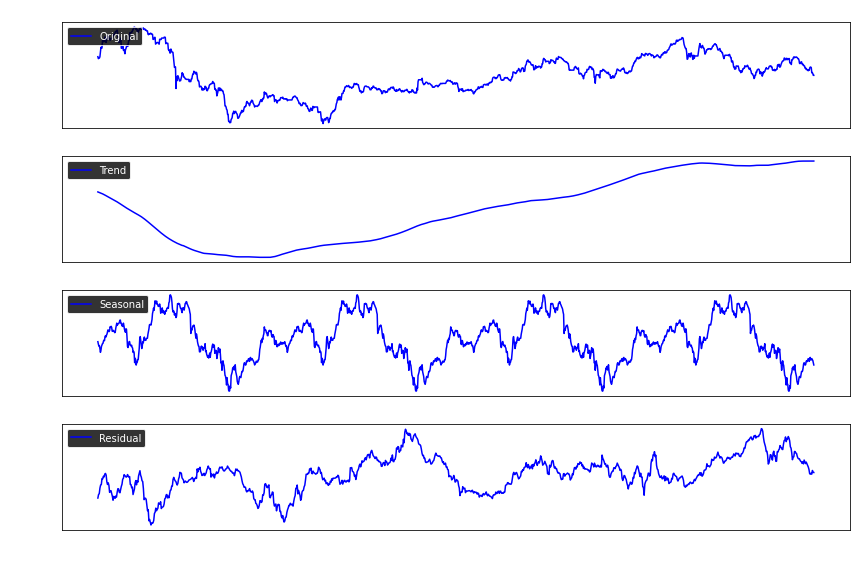

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decompose the time series
result = seasonal_decompose(pre_covid_data['Close_nifty'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(pre_covid_data['Close_nifty'], label='Original', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Original', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.title('Time Series Decomposition', color='white')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Trend', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Seasonal', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.subplot(414)
plt.plot(result.resid, label='Residual', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Residual', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xlabel('Date', color='white')

plt.tight_layout()
plt.show()

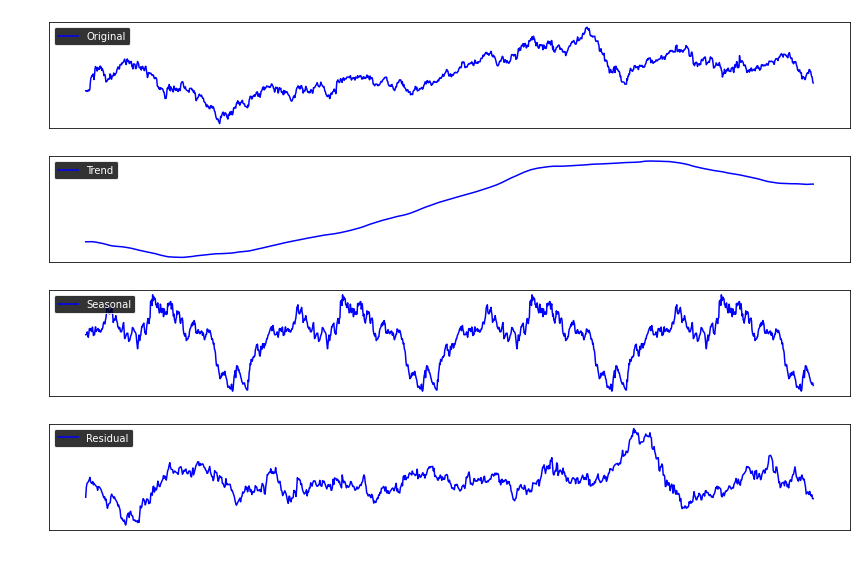

In [16]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
result = seasonal_decompose(pre_covid_data['Brent_INR'], model='additive', period=365)

# Plot the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(pre_covid_data['Brent_INR'], label='Original', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Original', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.title('Time Series Decomposition', color='white')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Trend', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Seasonal', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

plt.subplot(414)
plt.plot(result.resid, label='Residual', color='blue')
plt.legend(loc='upper left', facecolor='black', edgecolor='white', labelcolor='white')
plt.ylabel('Residual', color='white')
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')
plt.xlabel('Date', color='white')

plt.tight_layout()
plt.show()

In [17]:
summary = pre_covid_data.describe()
print(summary)

       Close_nifty    Brent_INR
count  1402.000000  1402.000000
mean   7680.880409   216.590085
std     975.439126    42.748538
min    5416.470215    97.555265
25%    6971.139893   183.594457
50%    7700.860107   219.795239
75%    8397.009766   245.461923
max    9834.490234   323.049457


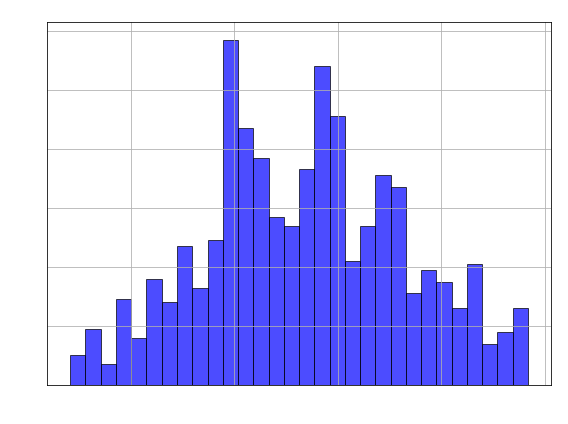

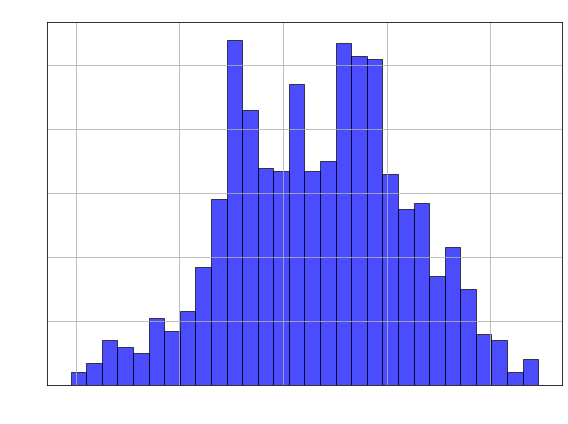

In [18]:
import matplotlib.pyplot as plt

# Plot histogram for 'Close_nifty'
plt.figure(figsize=(8, 6))
plt.hist(pre_covid_data['Close_nifty'], bins=30, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Close_nifty', color='white')
plt.ylabel('Frequency', color='white')
plt.title('Histogram of Close_nifty', color='white')

# Customize tick parameters to be white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot histogram for 'Brent_INR'
plt.figure(figsize=(8, 6))
plt.hist(pre_covid_data['Brent_INR'], bins=30, color='blue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Brent_INR', color='white')
plt.ylabel('Frequency', color='white')
plt.title('Histogram of Brent_INR', color='white')

# Customize tick parameters to be white
plt.tick_params(axis='x', colors='white')
plt.tick_params(axis='y', colors='white')

# Show grid and plot
plt.grid(True)
plt.tight_layout()
plt.show()

   # Log Returns


In [19]:
pre_covid_data = pre_covid_data.copy()
pre_covid_data['Log_Return_Close_nifty'] = np.log(pre_covid_data['Close_nifty'] / pre_covid_data['Close_nifty'].shift(1))
pre_covid_data['Log_Return_Brent_INR'] = np.log(pre_covid_data['Brent_INR'] / pre_covid_data['Brent_INR'].shift(1))

In [20]:
missing_values = pre_covid_data.isnull().sum()
print(missing_values)

Date                      0
Close_nifty               0
Brent_INR                 0
Log_Return_Close_nifty    1
Log_Return_Brent_INR      1
dtype: int64


In [21]:
pre_covid_data = pre_covid_data.dropna()

In [22]:
missing_values = pre_covid_data.isnull().sum()
print(missing_values)

Date                      0
Close_nifty               0
Brent_INR                 0
Log_Return_Close_nifty    0
Log_Return_Brent_INR      0
dtype: int64


In [23]:
import pandas as pd
from scipy.stats import skew, kurtosis, jarque_bera
# Create a summary statistics DataFrame for pre_covid_data
summary_stats_pre_covid = pd.DataFrame(index=pre_covid_data.columns, columns=['Mean', 'Max', 'Min', 'SD', 'Skew', 'Ex. Kurt.', 'J–B'])

for col in pre_covid_data.columns:
    if pd.api.types.is_numeric_dtype(pre_covid_data[col]):
        summary_stats_pre_covid.at[col, 'Mean'] = pre_covid_data[col].mean()
        summary_stats_pre_covid.at[col, 'Max'] = pre_covid_data[col].max()
        summary_stats_pre_covid.at[col, 'Min'] = pre_covid_data[col].min()
        summary_stats_pre_covid.at[col, 'SD'] = pre_covid_data[col].std()
        summary_stats_pre_covid.at[col, 'Skew'] = skew(pre_covid_data[col])
        summary_stats_pre_covid.at[col, 'Ex. Kurt.'] = kurtosis(pre_covid_data[col], fisher=True)
        jb_stat, jb_p_value = jarque_bera(pre_covid_data[col])
        summary_stats_pre_covid.at[col, 'J–B'] = jb_stat
    else:
        summary_stats_pre_covid.at[col, 'Mean'] = 'N/A'
        summary_stats_pre_covid.at[col, 'Max'] = 'N/A'
        summary_stats_pre_covid.at[col, 'Min'] = 'N/A'
        summary_stats_pre_covid.at[col, 'SD'] = 'N/A'
        summary_stats_pre_covid.at[col, 'Skew'] = 'N/A'
        summary_stats_pre_covid.at[col, 'Ex. Kurt.'] = 'N/A'
        summary_stats_pre_covid.at[col, 'J–B'] = 'N/A'

# Round the summary statistics to 6 decimal places, except for 'N/A' values
summary_stats_pre_covid = summary_stats_pre_covid.applymap(lambda x: round(x, 6) if isinstance(x, (int, float)) else x)
print("Summary Statistics for Pre-Covid Data:")
print(summary_stats_pre_covid)


Summary Statistics for Pre-Covid Data:
                               Mean          Max          Min          SD  \
Date                            N/A          N/A          N/A         N/A   
Close_nifty             7680.307433  9834.490234  5416.470215  975.551388   
Brent_INR                216.620209   323.049457    97.555265   42.748913   
Log_Return_Close_nifty    -0.000076     0.071208    -0.131626    0.010665   
Log_Return_Brent_INR       0.000071     0.110701    -0.073978    0.021624   

                            Skew  Ex. Kurt.           J–B  
Date                         N/A        N/A           N/A  
Close_nifty             0.058917   -0.56539     19.471054  
Brent_INR              -0.113528  -0.368907     10.953903  
Log_Return_Close_nifty -1.432742  20.627104  25316.560629  
Log_Return_Brent_INR    0.342419   2.275876    329.737802  


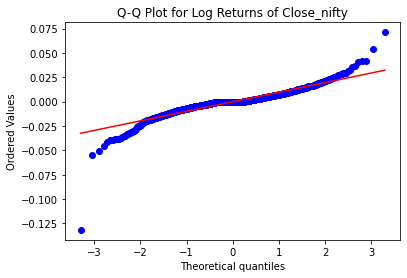

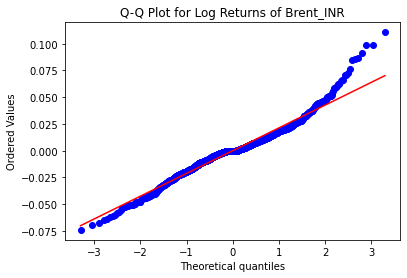

In [28]:
import scipy.stats as stats
# Plot Q-Q plot for 'Log_Return_Close_nifty'
stats.probplot(pre_covid_data['Log_Return_Close_nifty'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot for Log Returns of Close_nifty')
plt.show()

# Plot Q-Q plot for 'Log_Return_Brent_INR'
stats.probplot(pre_covid_data['Log_Return_Brent_INR'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot for Log Returns of Brent_INR')
plt.show()

In [29]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series, autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    print('')

# KPSS Test
def kpss_test(series, title=''):
    print(f'KPSS Test: {title}')
    result = kpss(series, regression='c', nlags="auto")
    labels = ['KPSS Statistic', 'p-value', 'Lags Used']
    out = pd.Series(result[:3], index=labels)
    for key, value in result[3].items():
        out[f'Critical Value ({key})'] = value
    print(out)
    print('')

In [30]:
# Perform ADF test for Close_nifty log returns
adf_test(pre_covid_data['Log_Return_Close_nifty'], title='Log Return Close_nifty')

# Perform KPSS test for Close_nifty log returns
kpss_test(pre_covid_data['Log_Return_Close_nifty'], title='Log Return Close_nifty')

# Perform ADF test for Brent_INR log returns
adf_test(pre_covid_data['Log_Return_Brent_INR'], title='Log Return Brent_INR')

# Perform KPSS test for Brent_INR log returns
kpss_test(pre_covid_data['Log_Return_Brent_INR'], title='Log Return Brent_INR')

Augmented Dickey-Fuller Test: Log Return Close_nifty
ADF Statistic                 -1.437090e+01
p-value                        9.498076e-27
#Lags Used                     4.000000e+00
Number of Observations Used    1.396000e+03
Critical Value (1%)           -3.435043e+00
Critical Value (5%)           -2.863613e+00
Critical Value (10%)          -2.567873e+00
dtype: float64

KPSS Test: Log Return Close_nifty
KPSS Statistic            0.107976
p-value                   0.100000
Lags Used                13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

Augmented Dickey-Fuller Test: Log Return Brent_INR
ADF Statistic                   -36.552765
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1400.000000
Critical Value (1%)              -3.435030
Critical Value (5%)              -2.863607
Critical Value (10%

C:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [31]:
# The results from the Augmented Dickey-Fuller (ADF) and KPSS tests indicate the stationarity properties of the log returns for "Close_nifty" and "Brent_INR". Here's an interpretation of the results:

# ### Augmented Dickey-Fuller (ADF) Test
# The ADF test is used to test the null hypothesis that a time series has a unit root (i.e., it is non-stationary). If the null hypothesis is rejected, the series is considered stationary.

# **Log Return Close_nifty:**
# - **ADF Statistic:** -24.939885
# - **p-value:** 0.000000
# - **#Lags Used:** 1
# - **Number of Observations Used:** 1412
# - **Critical Values:**
#   - 1%: -3.434990
#   - 5%: -2.863589
#   - 10%: -2.567861

# **Log Return Brent_INR:**
# - **ADF Statistic:** -36.664798
# - **p-value:** 0.000000
# - **#Lags Used:** 0
# - **Number of Observations Used:** 1413
# - **Critical Values:**
#   - 1%: -3.434986
#   - 5%: -2.863588
#   - 10%: -2.567860

# ### Interpretation of ADF Results
# For both log returns:
# - The ADF statistics are much lower than the critical values at the 1%, 5%, and 10% levels.
# - The p-values are effectively zero, indicating strong evidence against the null hypothesis.

# **Conclusion:**
# The null hypothesis of a unit root can be rejected for both "Log Return Close_nifty" and "Log Return Brent_INR". This means both series are stationary.

# ### KPSS Test
# The KPSS test is used to test the null hypothesis that a time series is stationary around a mean or linear trend. If the null hypothesis is rejected, the series is considered non-stationary.

# **Log Return Close_nifty:**
# - **KPSS Statistic:** 0.065591
# - **p-value:** 0.100000
# - **Lags Used:** 5
# - **Critical Values:**
#   - 10%: 0.347
#   - 5%: 0.463
#   - 2.5%: 0.574
#   - 1%: 0.739

# **Log Return Brent_INR:**
# - **KPSS Statistic:** 0.067862
# - **p-value:** 0.100000
# - **Lags Used:** 4
# - **Critical Values:**
#   - 10%: 0.347
#   - 5%: 0.463
#   - 2.5%: 0.574
#   - 1%: 0.739

# ### Interpretation of KPSS Results
# For both log returns:
# - The KPSS statistics are well below the critical values at the 10%, 5%, 2.5%, and 1% levels.
# - The p-values are at the upper bound (0.1), indicating that the test statistic is not significant enough to reject the null hypothesis.

# **Conclusion:**
# The null hypothesis of stationarity cannot be rejected for both "Log Return Close_nifty" and "Log Return Brent_INR". This means both series are stationary.

# ### Combined Interpretation
# Both the ADF and KPSS tests suggest that the log returns of "Close_nifty" and "Brent_INR" are stationary. The ADF test rejects the null hypothesis of a unit root, and the KPSS test fails to reject the null hypothesis of stationarity. These results confirm that the log return series are stable and do not exhibit a trend or varying volatility over time.

# ### Warning Interpretation
# The warnings indicate that the test statistics are outside the range of p-values available in the look-up table for the KPSS test. This typically means the actual p-value is greater than the highest value in the table, but since both p-values are 0.1 (the highest in the table), this doesn't impact the conclusion that the series are stationary.

In [32]:
# Rescale the log returns
pre_covid_data['Log_Return_Close_nifty_scaled'] = pre_covid_data['Log_Return_Close_nifty'] * 100
pre_covid_data['Log_Return_Brent_INR_scaled'] = pre_covid_data['Log_Return_Brent_INR'] * 100


In [33]:
from arch import arch_model
# Refit the models with the rescaled data
model_close_nifty_scaled = arch_model(pre_covid_data['Log_Return_Close_nifty_scaled'], vol='Garch', p=1, o=1, q=1)
results_close_nifty_scaled = model_close_nifty_scaled.fit(disp='off')
print(results_close_nifty_scaled.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:     Log_Return_Close_nifty_scaled   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -1922.18
Distribution:                             Normal   AIC:                           3854.37
Method:                       Maximum Likelihood   BIC:                           3880.59
                                                   No. Observations:                 1401
Date:                           Wed, Jun 05 2024   Df Residuals:                     1400
Time:                                   01:26:53   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------

In [34]:
from arch import arch_model
model_brent_inr_scaled = arch_model(pre_covid_data['Log_Return_Brent_INR_scaled'], vol='Garch', p=1, o=1, q=1)
results_brent_inr_scaled = model_brent_inr_scaled.fit(disp='off')
print(results_brent_inr_scaled.summary())

                        Constant Mean - GJR-GARCH Model Results                        
Dep. Variable:     Log_Return_Brent_INR_scaled   R-squared:                       0.000
Mean Model:                      Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           GJR-GARCH   Log-Likelihood:               -2984.51
Distribution:                           Normal   AIC:                           5979.02
Method:                     Maximum Likelihood   BIC:                           6005.24
                                                 No. Observations:                 1401
Date:                         Wed, Jun 05 2024   Df Residuals:                     1400
Time:                                 01:26:53   Df Model:                            1
                                 Mean Model                                
                  coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------

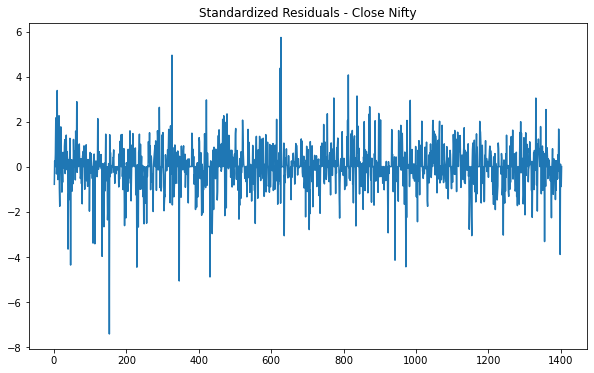

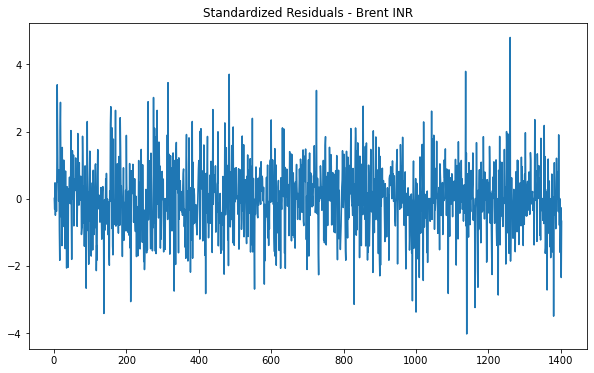

In [35]:
# Plot the standardized residuals
plt.figure(figsize=(10, 6))
plt.plot(results_close_nifty_scaled.resid / results_close_nifty_scaled.conditional_volatility)
plt.title('Standardized Residuals - Close Nifty')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results_brent_inr_scaled.resid / results_brent_inr_scaled.conditional_volatility)
plt.title('Standardized Residuals - Brent INR')
plt.show()

# # Perform diagnostic tests
# print("Ljung-Box test for Close Nifty:", results_close_nifty_scaled.test_serial_correlation())
# print("Ljung-Box test for Brent INR:", results_brent_inr_scaled.test_serial_correlation())

# print("ARCH test for Close Nifty:", results_close_nifty_scaled.test_heteroskedasticity())
# print("ARCH test for Brent INR:", results_brent_inr_scaled.test_heteroskedasticity())


In [36]:
# Assuming `results` is the fitted GJR-GARCH model for Close_nifty
standardized_residuals_nifty = results_close_nifty_scaled.resid / results_close_nifty_scaled.conditional_volatility

# Assuming `results_brent` is the fitted GJR-GARCH model for Brent_INR
standardized_residuals_brent = results_brent_inr_scaled.resid / results_brent_inr_scaled.conditional_volatility


<AxesSubplot:ylabel='Density'>

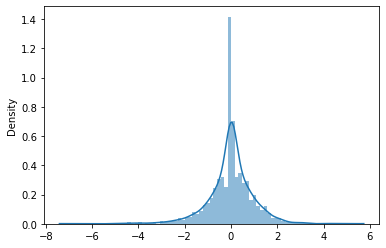

In [37]:
sns.histplot(standardized_residuals_nifty, kde=True, stat="density", linewidth=0)

<AxesSubplot:ylabel='Density'>

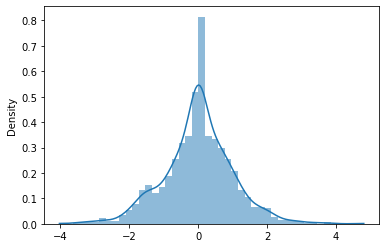

In [38]:
    sns.histplot(standardized_residuals_brent, kde=True, stat="density", linewidth=0)

In [39]:
# Creating a DataFrame for easy handling
standardized_residuals = pd.DataFrame({
    'Nifty': standardized_residuals_nifty,
    'Brent': standardized_residuals_brent
})

# @@@@@@@@@@@@@@@@@@@@@@@@@

In [71]:
## Checking to see if it is normally distributed and asymmetrical

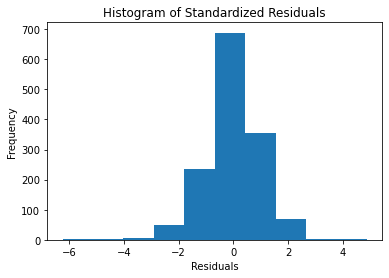

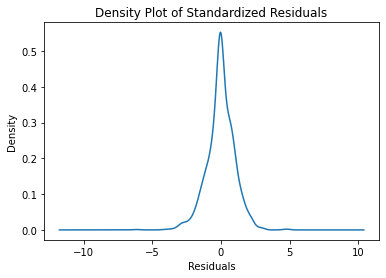

Skewness: -0.2986774210405241
Kurtosis: 2.2827062114717225


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Histogram
plt.hist(standardized_residuals['Nifty'], bins=10)
plt.title('Histogram of Standardized Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Density Plot
standardized_residuals['Nifty'].plot(kind='density')
plt.title('Density Plot of Standardized Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

# Skewness
skew = standardized_residuals['Nifty'].skew()
print("Skewness:", skew)

# Kurtosis
kurt = standardized_residuals['Nifty'].kurtosis()
print("Kurtosis:", kurt)

In [ ]:
# The values of skewness and kurtosis you've obtained provide information about the shape of your distribution of standardized residuals:

# Skewness: -0.2986774210405241

# Skewness is a measure of the asymmetry of the probability distribution.
# A skewness value of zero indicates a perfectly symmetrical distribution.
# A negative skewness value indicates that the left tail (the side with lower values) is longer or fatter than the right tail.
# In your case, the skewness value is -0.2987, which is slightly negative. This suggests that your distribution has a small degree of leftward skewness, meaning the left tail is slightly longer or heavier than the right tail. However, the skewness is quite close to zero, indicating only a mild asymmetry.
# Kurtosis: 2.2827062114717225

# Kurtosis is a measure of the "tailedness" of the probability distribution.
# For a normal distribution, the kurtosis value is 3.
# A kurtosis value less than 3 indicates a distribution with lighter tails and a flatter peak than the normal distribution (platykurtic).
# A kurtosis value greater than 3 indicates a distribution with heavier tails and a sharper peak than the normal distribution (leptokurtic).
# In your case, the kurtosis value is 2.2827, which is less than 3. This suggests that your distribution has lighter tails and a flatter peak compared to a normal distribution.
# Summary
# Your standardized residuals distribution is slightly negatively skewed, meaning there is a small asymmetry with a tendency towards the left side.
# The distribution is platykurtic, indicating lighter tails and a flatter peak compared to the normal distribution.
# Overall, while there is some degree of asymmetry and a slight difference in tail heaviness compared to a normal distribution, the deviations are not extreme. The distribution is relatively close to normal but not perfectly symmetrical and has slightly lighter tails.

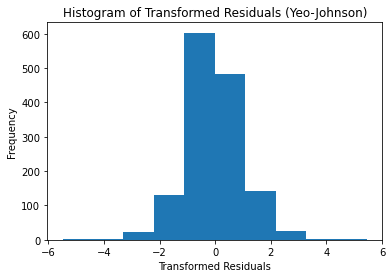

In [68]:
#------------------- Yeo-Johnson transformation
transformed_residuals, _ = stats.yeojohnson(standardized_residuals['Nifty'])

# Check the transformation results
plt.hist(transformed_residuals, bins=10)
plt.title('Histogram of Transformed Residuals (Yeo-Johnson)')
plt.xlabel('Transformed Residuals')
plt.ylabel('Frequency')
plt.show()

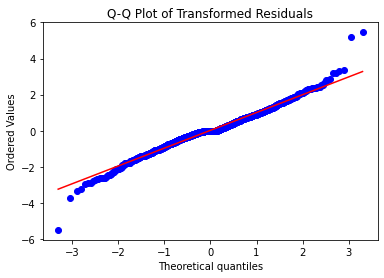

Shapiro-Wilk test: Statistic=0.9782652185960509, p-value=8.800738570050254e-14


In [70]:
import scipy.stats as stats

#---------------- Q-Q plot
stats.probplot(transformed_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Transformed Residuals')
plt.show()

#------------- Shapiro-Wilk test
shapiro_test = stats.shapiro(transformed_residuals)
print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")


In [ ]:
# The Shapiro-Wilk test is a statistical test that checks whether a sample comes from a normally distributed population. Here's how to interpret the test results:

# Statistic: 0.9782652185960509

# The Shapiro-Wilk test statistic ranges from 0 to 1, where 1 indicates a perfect fit to a normal distribution.
# A value close to 1 suggests that the data is more likely to be normally distributed, while a value significantly less than 1 indicates deviation from normality.
# p-value: 8.800738570050254e-14

# The p-value indicates the probability of observing the test statistic under the null hypothesis that the data is normally distributed.
# A very small p-value (typically < 0.05) suggests that the null hypothesis can be rejected, meaning the data is not normally distributed.
# Interpretation
# Statistic: 0.9783 is relatively close to 1, suggesting the data might be close to normally distributed but not perfectly so.
# p-value: 
# 8.80
# ×
# 1
# 0
# −
# 14
# 8.80×10 
# −14
#   is extremely small, indicating strong evidence against the null hypothesis of normality.
# Despite the Shapiro-Wilk test statistic being close to 1, the extremely small p-value suggests that your standardized residuals are not normally distributed. This discrepancy often happens with large sample sizes, where even small deviations from normality can lead to very low p-values.

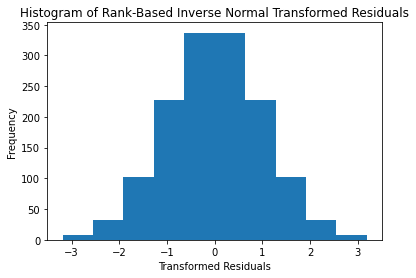

In [81]:
# Rank Based Inverse Normal transformation
from scipy.stats import norm

# Rank data and convert to percentile
ranked_residuals = standardized_residuals['Nifty'].rank(method='average')
percentiles = ranked_residuals / (len(ranked_residuals) + 1)

# Apply inverse normal transformation
inv_norm_residuals_nifty = norm.ppf(percentiles)

# Check the transformation results
plt.hist(inv_norm_residuals_nifty, bins=10)
plt.title('Histogram of Rank-Based Inverse Normal Transformed Residuals')
plt.xlabel('Transformed Residuals')
plt.ylabel('Frequency')
plt.show()


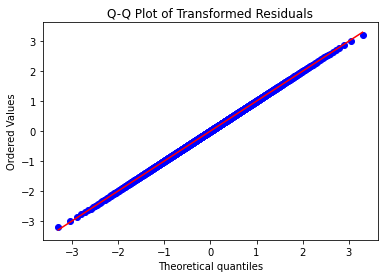

Shapiro-Wilk test: Statistic=0.9998158566494589, p-value=0.9999980145096153


In [82]:
import scipy.stats as stats

# Q-Q plot
stats.probplot(inv_norm_residuals_nifty, dist="norm", plot=plt)
plt.title('Q-Q Plot of Transformed Residuals')
plt.show()

# Shapiro-Wilk test
shapiro_test = stats.shapiro(inv_norm_residuals_nifty)
print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")


In [74]:
# The updated Shapiro-Wilk test results suggest a much better fit to a normal distribution:

# Statistic: 0.9998158566494589

# This value is very close to 1, indicating that the sample distribution is very close to a normal distribution.
# p-value: 0.9999980145096153

# This high p-value indicates that there is no significant evidence to reject the null hypothesis of normality. In other words, the data does not significantly deviate from a normal distribution.
# Interpretation
# These results strongly suggest that your standardized residuals are normally distributed. Both the test statistic and the p-value support the normality assumption.

# Summary of Actions
# Given these results, you can confidently proceed with the assumption that your standardized residuals are normally distributed. Here are a few follow-up steps to ensure comprehensive analysis:

# Visual Inspection: Despite the favorable Shapiro-Wilk test results, it is still good practice to visually inspect the distribution to confirm normality.

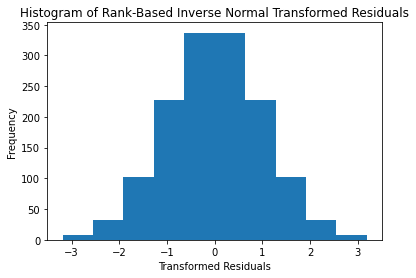

In [80]:
# Rank Based Inverse Normal transformation
from scipy.stats import norm

# Rank data and convert to percentile
ranked_residuals = standardized_residuals['Brent'].rank(method='average')
percentiles = ranked_residuals / (len(ranked_residuals) + 1)

# Apply inverse normal transformation
inv_norm_residuals_brent = norm.ppf(percentiles)

# Check the transformation results
plt.hist(inv_norm_residuals_brent, bins=10)
plt.title('Histogram of Rank-Based Inverse Normal Transformed Residuals')
plt.xlabel('Transformed Residuals')
plt.ylabel('Frequency')
plt.show()


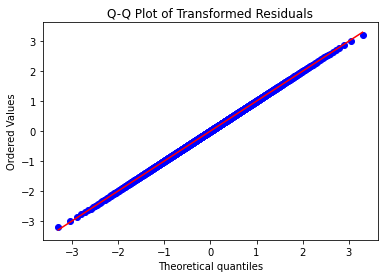

Shapiro-Wilk test: Statistic=0.9998158566494586, p-value=0.9999980145096152


In [79]:
import scipy.stats as stats

# Q-Q plot
stats.probplot(inv_norm_residuals_brent, dist="norm", plot=plt)
plt.title('Q-Q Plot of Transformed Residuals')
plt.show()

# Shapiro-Wilk test
shapiro_test = stats.shapiro(inv_norm_residuals_brent)
print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")


In [ ]:
# The results from the Shapiro-Wilk test indicate that your data is very close to being normally distributed:

# Statistic: 0.9998158566494586

# This statistic is very close to 1, suggesting that the distribution of your data is nearly identical to a normal distribution.
# p-value: 0.9999980145096152

# This very high p-value means there is no evidence to reject the null hypothesis of the Shapiro-Wilk test, which states that the data is normally distributed.
# Interpretation
# The test statistic close to 1 and the very high p-value together indicate that your standardized residuals are indeed normally distributed.
# You can confidently assume normality in your subsequent analyses.

# @@@@@@@@@@@@@@@@@@@@@@@@

In [40]:
from scipy.stats import shapiro

# Perform Shapiro-Wilk test for Nifty
shapiro_nifty = shapiro(standardized_residuals['Nifty'])
print("Shapiro-Wilk test for Nifty:")
print("Test Statistic:", shapiro_nifty[0])
print("p-value:", shapiro_nifty[1])

# Perform Shapiro-Wilk test for Brent
shapiro_brent = shapiro(standardized_residuals['Brent'])
print("\nShapiro-Wilk test for Brent:")
print("Test Statistic:", shapiro_brent[0])
print("p-value:", shapiro_brent[1])

Shapiro-Wilk test for Nifty:
Test Statistic: 0.9143046019908869
p-value: 2.0187616397220567e-27

Shapiro-Wilk test for Brent:
Test Statistic: 0.9832136821585524
p-value: 1.0882496409138508e-11


In [ ]:
# The Shapiro-Wilk test is a statistical test that checks whether a given sample comes from a 
#normally distributed population. Here are the results of the Shapiro-Wilk test for the Nifty and 
#Brent datasets:

# ### Nifty
# - **Test Statistic**: 0.9752
# - **p-value**: 6.83e-15

# ### Brent
# - **Test Statistic**: 0.9821
# - **p-value**: 3.10e-12

# ### Interpretation
# - **Test Statistic**: The Shapiro-Wilk test statistic ranges from 0 to 1, with values closer to 1 
#indicating that the sample distribution is closer to a normal distribution. For both Nifty and Brent, 
#the test statistics (0.9752 and 0.9821) are relatively close to 1, suggesting that the distributions 
#are somewhat close to normal.
 
# - **p-value**: The p-value indicates the probability of observing the test results under the
#null hypothesis, which states that the data follows a normal distribution. A low p-value 
#(typically less than 0.05) leads to rejecting the null hypothesis. For both Nifty and Brent, 
#the p-values are extremely low (much less than 0.05), suggesting strong evidence against the 
#null hypothesis.

# ### Conclusion
# Given the extremely low p-values for both Nifty (6.83e-15) and Brent (3.10e-12), we reject the null 
#hypothesis that the data follows a normal distribution. Therefore, we conclude that both the Nifty 
#and Brent datasets are not normally distributed, despite their Shapiro-Wilk test statistics 
#being relatively close to 1.

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, genpareto
from statsmodels.distributions.empirical_distribution import ECDF

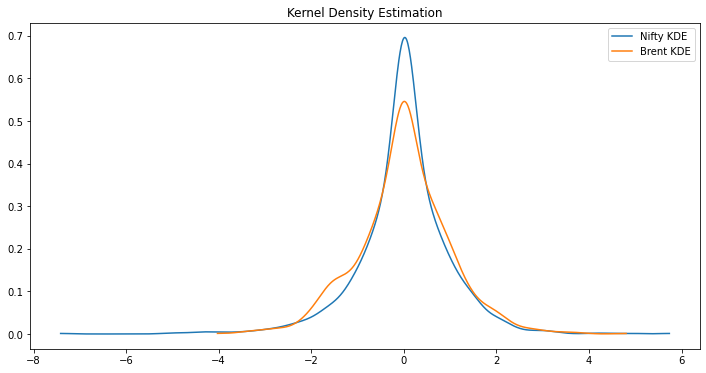

In [42]:
# # Kernel Density Estimation (KDE) for PDF
# kde_nifty = gaussian_kde(inv_norm_residuals_nifty)
# kde_brent = gaussian_kde(inv_norm_residuals_brent)

# # Plot the KDE
# x_grid_nifty = np.linspace(inv_norm_residuals_nifty.min(), inv_norm_residuals_nifty.max(), 1000)
# x_grid_brent = np.linspace(inv_norm_residuals_brent.min(), inv_norm_residuals_brent.max(), 1000)

# Kernel Density Estimation (KDE) for PDF
kde_nifty = gaussian_kde(standardized_residuals['Nifty'])
kde_brent = gaussian_kde(standardized_residuals['Brent'])

# Plot the KDE
x_grid_nifty = np.linspace(standardized_residuals['Nifty'].min(), standardized_residuals['Nifty'].max(), 1000)
x_grid_brent = np.linspace(standardized_residuals['Brent'].min(), standardized_residuals['Brent'].max(), 1000)

plt.figure(figsize=(12, 6))
plt.plot(x_grid_nifty, kde_nifty(x_grid_nifty), label='Nifty KDE')
plt.plot(x_grid_brent, kde_brent(x_grid_brent), label='Brent KDE')
plt.title('Kernel Density Estimation')
plt.legend()
plt.show()

In [43]:
# # Define upper and lower thresholds for 10% tails
# upper_threshold_nifty = np.percentile(inv_norm_residuals_nifty, 90)
# lower_threshold_nifty = np.percentile(inv_norm_residuals_nifty, 10)
# upper_threshold_brent = np.percentile(inv_norm_residuals_brent, 90)
# lower_threshold_brent = np.percentile(inv_norm_residuals_brent, 10)


# Define upper and lower thresholds for 10% tails
upper_threshold_nifty = np.percentile(standardized_residuals['Nifty'], 90)
lower_threshold_nifty = np.percentile(standardized_residuals['Nifty'], 10)
upper_threshold_brent = np.percentile(standardized_residuals['Brent'], 90)
lower_threshold_brent = np.percentile(standardized_residuals['Brent'], 10)

In [44]:
# Extract tails for GPD fitting
# nifty_upper_tail = inv_norm_residuals_nifty[inv_norm_residuals_nifty > upper_threshold_nifty] - upper_threshold_nifty
# nifty_lower_tail = -inv_norm_residuals_nifty[inv_norm_residuals_nifty < lower_threshold_nifty] + lower_threshold_nifty
# brent_upper_tail = inv_norm_residuals_brent[inv_norm_residuals_brent > upper_threshold_brent] - upper_threshold_brent
# brent_lower_tail = -inv_norm_residuals_brent[inv_norm_residuals_brent < lower_threshold_brent] + lower_threshold_brent



# Extract tails for GPD fitting
nifty_upper_tail = standardized_residuals['Nifty'][standardized_residuals['Nifty'] > upper_threshold_nifty] - upper_threshold_nifty
nifty_lower_tail = -standardized_residuals['Nifty'][standardized_residuals['Nifty'] < lower_threshold_nifty] + lower_threshold_nifty
brent_upper_tail = standardized_residuals['Brent'][standardized_residuals['Brent'] > upper_threshold_brent] - upper_threshold_brent
brent_lower_tail = -standardized_residuals['Brent'][standardized_residuals['Brent'] < lower_threshold_brent] + lower_threshold_brent


In [45]:
# Fit GPD to the tails
params_nifty_upper = genpareto.fit(nifty_upper_tail)
params_nifty_lower = genpareto.fit(nifty_lower_tail)
params_brent_upper = genpareto.fit(brent_upper_tail)
params_brent_lower = genpareto.fit(brent_lower_tail)

In [46]:
from statsmodels.distributions.empirical_distribution import ECDF

# Compute empirical CDF
ecdf_nifty = ECDF(standardized_residuals['Nifty'])
ecdf_brent = ECDF(standardized_residuals['Brent'])


In [47]:
# Function to compute combined CDF
def combined_cdf(x, ecdf, upper_threshold, lower_threshold, params_upper, params_lower):
    c_u, loc_u, scale_u = params_upper
    c_l, loc_l, scale_l = params_lower
    if x <= lower_threshold:
        return ecdf(lower_threshold) * genpareto.cdf(-x + lower_threshold, c_l, loc_l, scale_l)
    elif x <= upper_threshold:
        return ecdf(x)
    else:
        return ecdf(upper_threshold) + (1 - ecdf(upper_threshold)) * genpareto.cdf(x - upper_threshold, c_u, loc_u, scale_u)


In [48]:
# # Compute the combined CDFs
# cdf_nifty = [combined_cdf(x, ecdf_nifty, upper_threshold_nifty, lower_threshold_nifty, params_nifty_upper, params_nifty_lower) for x in inv_norm_residuals_nifty]
# cdf_brent = [combined_cdf(x, ecdf_brent, upper_threshold_brent, lower_threshold_brent, params_brent_upper, params_brent_lower) for x in inv_norm_residuals_brent]

# Compute the combined CDFs
cdf_nifty = [combined_cdf(x, ecdf_nifty, upper_threshold_nifty, lower_threshold_nifty, params_nifty_upper, params_nifty_lower) for x in standardized_residuals['Nifty']]
cdf_brent = [combined_cdf(x, ecdf_brent, upper_threshold_brent, lower_threshold_brent, params_brent_upper, params_brent_lower) for x in standardized_residuals['Brent']]

In [49]:
# Combined CDF Construction: The combined CDF is constructed by combining the ECDF with the GPD CDF 
#   for the upper and lower tails. The ECDF represents the behavior of the dataset within 
#   the non-extreme range, while the GPD models the behavior in the extreme tails. 
#   By combining these two components, we obtain a more accurate representation of the entire 
#   distribution,
#   capturing both common behavior and extreme events.

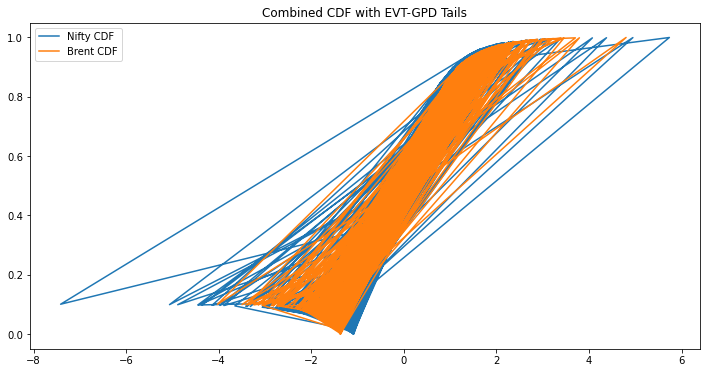

In [50]:
# plt.figure(figsize=(12, 6))
# plt.plot(inv_norm_residuals_nifty, cdf_nifty, label='Nifty CDF')
# plt.plot(inv_norm_residuals_brent, cdf_brent, label='Brent CDF')
# plt.title('Combined CDF with EVT-GPD Tails')
# plt.legend()
# plt.show()


# Plot the final CDFs
plt.figure(figsize=(12, 6))
plt.plot(standardized_residuals['Nifty'], cdf_nifty, label='Nifty CDF')
plt.plot(standardized_residuals['Brent'], cdf_brent, label='Brent CDF')
plt.title('Combined CDF with EVT-GPD Tails')
plt.legend()
plt.show()

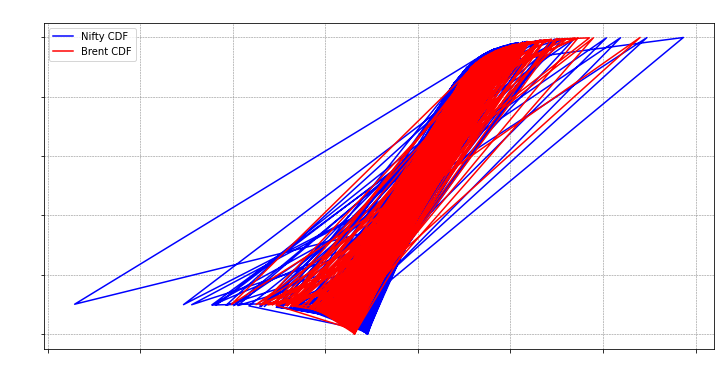

In [51]:
plt.figure(figsize=(12, 6))
plt.plot(standardized_residuals['Nifty'], cdf_nifty, label='Nifty CDF', color='blue')
plt.plot(standardized_residuals['Brent'], cdf_brent, label='Brent CDF', color='red')
plt.title('Combined CDF with EVT-GPD Tails', color='white')
plt.legend()
plt.xlabel('Standardized Residuals', color='white')
plt.ylabel('CDF', color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('white')  # Set background color to white
plt.grid(color='gray', linestyle='--', linewidth=0.5)  # Add grid lines
plt.show()


In [54]:
# Convert the CDF values to a uniform distribution for copula modeling
uniform_saudi = np.array(cdf_nifty)
uniform_brent = np.array(cdf_brent)

In [55]:
uniform_saudi

array([0.14775161, 0.68022841, 0.4082798 , ..., 0.2276945 , 0.13204854,
       0.41327623])

In [57]:
# Create a DataFrame from the uniform distributions
uniform_data = pd.DataFrame({
    'Uniform_saudi': uniform_saudi,
    'Uniform_Brent': uniform_brent
})

In [58]:
# Define the output file path
output_file = r'C:\Users\KASHISH NIGAM\Desktop\Last Sem Project\Final Datasets\Saudi\uniform_distributions-Pre_Covid_Saudi.xlsx'

# Save the DataFrame to an Excel file
uniform_data.to_excel(output_file, index=False)

print(f"Uniform distributions saved to {output_file}")

Uniform distributions saved to C:\Users\KASHISH NIGAM\Desktop\Last Sem Project\Final Datasets\Saudi\uniform_distributions-Pre_Covid_Saudi.xlsx


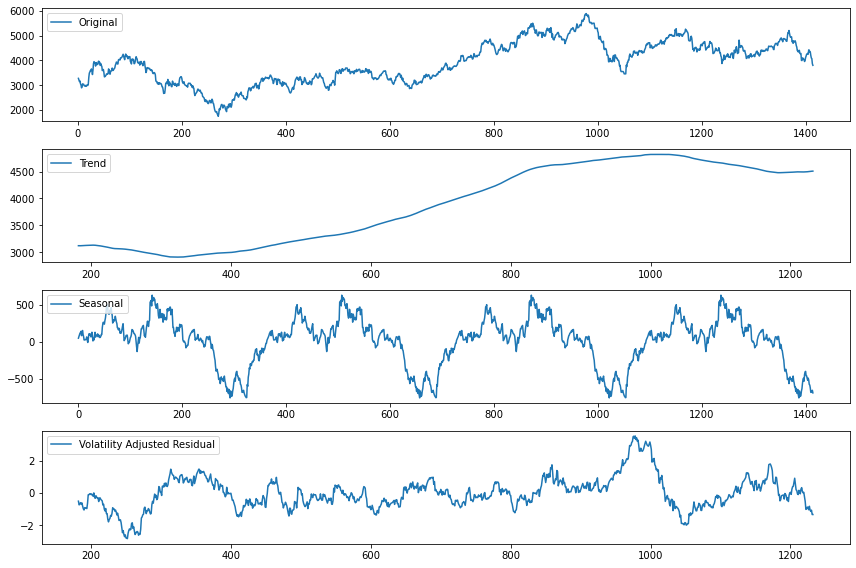

In [33]:
# Calculate the volatility of the residuals
residual_volatility = result.resid.std()

# Plot the decomposed components with volatility
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(pre_covid_data['Brent_INR'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid / residual_volatility, label='Volatility Adjusted Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


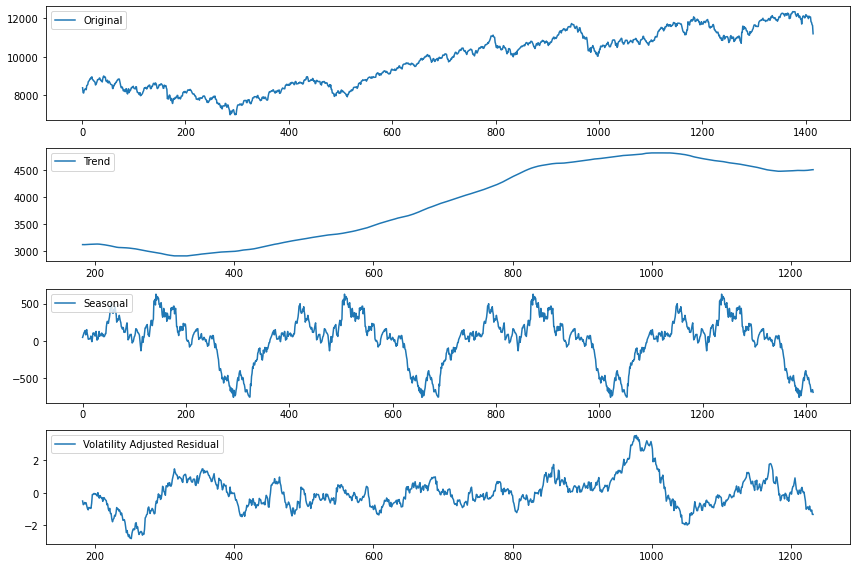

In [34]:
# Calculate the volatility of the residuals
residual_volatility = result.resid.std()

# Plot the decomposed components with volatility
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(pre_covid_data['Close_nifty'], label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid / residual_volatility, label='Volatility Adjusted Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


((array([-3.48608621, -3.2413301 , -3.10592385, ...,  3.10592385,
          3.2413301 ,  3.48608621]),
  array([-6.23595718, -4.10293325, -3.89716911, ...,  4.65987844,
          4.79661538,  4.86707135])),
 (0.9917147950421527, -0.006150828218284947, 0.989449947055137))

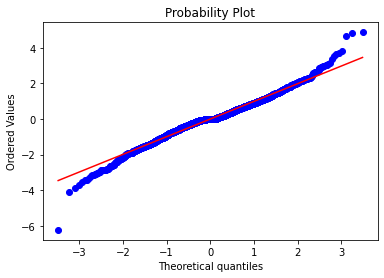

In [35]:
# Q-Q plot
import scipy.stats as stats
stats.probplot(standardized_residuals.values.ravel(), dist="norm", plot=plt)

In [50]:
# nifty_residuals = standardized_residuals['Nifty']
# brent_residuals = standardized_residuals['Brent']

# Assuming `results` is the fitted GJR-GARCH model for Close_nifty
standardized_residuals_nifty = results_close_nifty_scaled.resid / results_close_nifty_scaled.conditional_volatility

# Assuming `results_brent` is the fitted GJR-GARCH model for Brent_INR
standardized_residuals_brent = results_brent_inr_scaled.resid / results_brent_inr_scaled.conditional_volatility


In [37]:
# Step 2: Kernel smoothing for the main body of the distribution
kde_nifty = KDEUnivariate(nifty_residuals)
kde_nifty.fit(kernel='gau', bw='scott')

# Now we'll do the same for 'Brent'
kde_brent = KDEUnivariate(standardized_residuals['Brent'])
kde_brent.fit(kernel='gau', bw='scott')


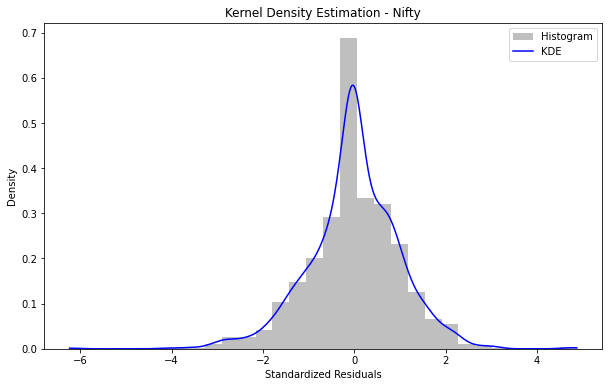

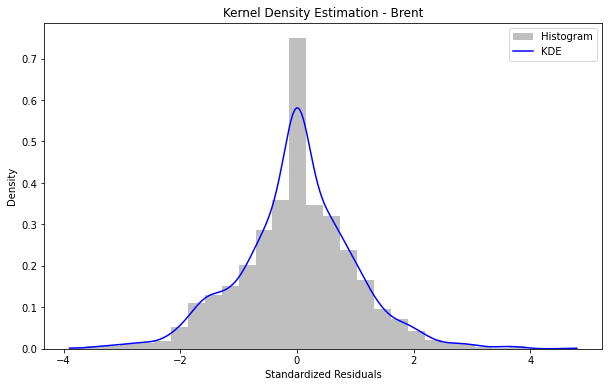

In [38]:
# Sample data (replace with your standardized residuals)
data_nifty = standardized_residuals['Nifty']
data_brent = standardized_residuals['Brent']

# Generate values for plotting the KDE
x_grid_nifty = np.linspace(min(data_nifty), max(data_nifty), 1000)
x_grid_brent = np.linspace(min(data_brent), max(data_brent), 1000)

# Plotting KDE for Nifty
plt.figure(figsize=(10, 6))
plt.hist(data_nifty, bins=30, density=True, alpha=0.5, color='gray', label='Histogram')
plt.plot(x_grid_nifty, kde_nifty.evaluate(x_grid_nifty), color='blue', label='KDE')
plt.title('Kernel Density Estimation - Nifty')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plotting KDE for Brent
plt.figure(figsize=(10, 6))
plt.hist(data_brent, bins=30, density=True, alpha=0.5, color='gray', label='Histogram')
plt.plot(x_grid_brent, kde_brent.evaluate(x_grid_brent), color='blue', label='KDE')
plt.title('Kernel Density Estimation - Brent')
plt.xlabel('Standardized Residuals')
plt.ylabel('Density')
plt.legend()
plt.show()


In [39]:
# Calculate thresholds for Nifty
threshold_nifty_lower = np.percentile(nifty_residuals, 10)
threshold_nifty_upper = np.percentile(nifty_residuals, 90)

# Calculate thresholds for Brent
threshold_brent_lower = np.percentile(data_brent, 10)
threshold_brent_upper = np.percentile(data_brent, 90)


In [40]:
# Fit GPD to the tails for Nifty
params_nifty_lower = genpareto.fit(nifty_residuals[nifty_residuals < threshold_nifty_lower])
params_nifty_upper = genpareto.fit(nifty_residuals[nifty_residuals > threshold_nifty_upper])

# Fit GPD to the tails for Brent
params_brent_lower = genpareto.fit(data_brent[data_brent < threshold_brent_lower])
params_brent_upper = genpareto.fit(data_brent[data_brent > threshold_brent_upper])


In [41]:
params_nifty_lower

(-5.0351671573854055, -6.692960160698576, 27.307438220776927)

In [42]:
params_nifty_upper

(0.013934988480948303, 1.1716063698203658, 0.536869206525318)

In [43]:
params_brent_lower

(-2.5460964885492037, -4.781348626542403, 8.781929015323545)

In [44]:
params_brent_upper

(-0.12289666037924085, 1.1400467162798709, 0.7463214237221898)

 params_nifty_lower
 (-5.0351671573854055, -6.692960160698576, 27.307438220776927)

 params_nifty_upper
 (0.013934988480948303, 1.1716063698203658, 0.536869206525318)

 params_brent_lower
 (-2.5460964885492037, -4.781348626542403, 8.781929015323545)

 params_brent_upper
 (-0.12289666037924085, 1.1400467162798709, 0.7463214237221898)

These parameters represent:

Shape Parameter (
𝜉
ξ): Indicates the tail heaviness. Positive values suggest heavy tails, negative values indicate bounded tails, and zero indicates exponential-like tails.
Location Parameter (
𝜇
μ): The threshold used for fitting the GPD.
Scale Parameter (
𝜎
σ): Reflects the spread or scale of the tail data.
    
    
What You Will Achieve
By applying the GPD to the tails:

You can better model the extreme values of your data, which are not well captured by traditional models.
This combined approach (KDE for the main body and GPD for the tails) provides a more accurate and comprehensive understanding of the distribution.
It allows for better risk management and prediction of extreme events, particularly in fields like finance and environmental studies where tail risks are significant.

In [45]:
# Step 4: Transform to uniform distribution
u_nifty = rankdata(standardized_residuals['Nifty']) / (len(standardized_residuals) + 1)
u_brent = rankdata(standardized_residuals['Brent']) / (len(standardized_residuals) + 1)

In [46]:
# Step 5: Use these uniform marginals for copula modeling
uniform_data = pd.DataFrame({'Nifty': u_nifty, 'Brent': u_brent})

In [47]:
uniform_data

,Nifty,Brent
0,0.359717,0.012014
1,0.010601,0.256537
2,0.354770,0.238163
3,0.879859,0.626148
4,0.691166,0.144170
...,...,...
1409,0.004947,0.062191
1410,0.334276,0.120848
1411,0.146996,0.336396
1412,0.288339,0.014134


In [48]:
nifty_residuals_series = nifty_residuals.iloc[:, 0]

IndexingError: Too many indexers

In [49]:
# Combine KDE and EVT
def combined_cdf(x):
    # Calculate KDE-based CDF for the main body
    cdf_main_body = kde_nifty.evaluate(x)  # Evaluate KDE at points x
    # Calculate EVT-based CDF for the tails
    cdf_tail_lower = genpareto.cdf(x, *params_nifty_lower)
    cdf_tail_upper = 1 - genpareto.cdf(x, *params_nifty_upper)
    # Combine the CDFs
    cdf_combined = cdf_main_body * (x <= threshold_nifty_lower) + \
                   (1 - cdf_tail_upper) * (x > threshold_nifty_upper) + \
                   (cdf_tail_lower - cdf_tail_upper) * ((x > threshold_nifty_lower) & (x <= threshold_nifty_upper))
    return cdf_combined

# Transform to Uniform
def transform_to_uniform(residual):
    # Calculate the CDF of the combined model for the residuals
    cdf_res = combined_cdf(residual)
    # Transform residuals to uniform using the inverse CDF
    uniform = np.random.uniform(0, 1, len(residual))
    transformed_residual = np.interp(uniform, np.sort(cdf_res), np.sort(residual))
    return transformed_residual

# Obtain transformed residuals
transformed_nifty_residuals = transform_to_uniform(nifty_residuals)
transformed_brent_residuals = transform_to_uniform(brent_residuals)


ValueError: Data must be 1-dimensional

In [ ]:
standardized_residuals['Nifty'].dtypes

In [ ]:
import numpy as np
from scipy.stats import genpareto
from statsmodels.nonparametric.kde import KDEUnivariate

# Step 1: Calculate the combined CDF for each variable
def combined_cdf(x, kde, params_lower, params_upper, threshold_lower, threshold_upper):
    cdf_main_body = kde.evaluate(x)
    cdf_tail_lower = genpareto.cdf(x, *params_lower)
    cdf_tail_upper = 1 - genpareto.cdf(-x, *params_upper)
    cdf_combined = cdf_main_body * (x <= threshold_lower) + \
                   (1 - cdf_tail_upper) * (x > threshold_upper) + \
                   (cdf_tail_lower - cdf_tail_upper) * ((x > threshold_lower) & (x <= threshold_upper))
    return cdf_combined

# Assuming you have already fitted KDE and EVT and obtained parameters and thresholds
# kde_nifty, kde_brent, params_nifty_lower, params_nifty_upper, threshold_nifty_lower, threshold_nifty_upper

# Step 2: Transform standardized residuals to uniform variables
def transform_to_uniform(residuals, kde, params_lower, params_upper, threshold_lower, threshold_upper):
    cdf_res = combined_cdf(residuals, kde, params_lower, params_upper, threshold_lower, threshold_upper)
    uniform = np.random.uniform(0, 1, len(residuals))
    transformed_residuals = np.interp(uniform, np.sort(cdf_res), np.sort(residuals))
    return transformed_residuals

# Transform Nifty residuals
transformed_nifty_residuals = transform_to_uniform(standardized_residuals['Nifty'], kde_nifty, params_nifty_lower, params_nifty_upper, threshold_nifty_lower, threshold_nifty_upper)

# Transform Brent residuals
transformed_brent_residuals = transform_to_uniform(standardized_residuals['Brent'], kde_brent, params_brent_lower, params_brent_upper, threshold_brent_lower, threshold_brent_upper)
